In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
from geopy.geocoders import Nominatim
import haversine as hs
from haversine import Unit
from modules_amazon import Location
import pickle

In [82]:
amazon_del = pd.read_csv("amazon_delivery.csv")
amazon_del.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


# **Introduction**  


## **Quick look column by column**  

### **Order_ID**  
Should be equivalent to PRIMARY KEY of a SQL table, only unique values. If so it can be removed when building a machine learning.  

In [83]:
duplicates_order = amazon_del.duplicated(subset=["Order_ID"])
print(amazon_del[duplicates_order])

Empty DataFrame
Columns: [Order_ID, Agent_Age, Agent_Rating, Store_Latitude, Store_Longitude, Drop_Latitude, Drop_Longitude, Order_Date, Order_Time, Pickup_Time, Weather, Traffic, Vehicle, Area, Delivery_Time, Category]
Index: []


All IDs are different.

### **Agent_Age**  
On first sight everything seems ok. Type: integer and no missing values.  


In [84]:
amazon_del["Agent_Age"].describe()

count    43739.000000
mean        29.567137
std          5.815155
min         15.000000
25%         25.000000
50%         30.000000
75%         35.000000
max         50.000000
Name: Agent_Age, dtype: float64

No Age = 0 or other abeerrant numbers.

### **Agent Rating**  
Based on the info() table there are apparent missing values (54).

In [85]:
missing_ratings = amazon_del[amazon_del["Agent_Rating"].isna()]
non_missing_ratings = amazon_del[~(amazon_del["Agent_Rating"].isna())]
len(missing_ratings)/len(amazon_del)

0.0012345961270262237

I could potentially remove the values as they represent less than 1%. But I will see if other values are missing.

In [86]:
missing_ratings["Traffic"].value_counts(dropna=False)

Traffic
Low        23
Jam        15
Medium     14
High        2
Name: count, dtype: int64

In [87]:
missing_ratings["Weather"].value_counts(dropna=False)

Weather
Windy         12
Sunny         11
Cloudy        11
Stormy         8
Sandstorms     7
Fog            5
Name: count, dtype: int64

I can remove them. There are no obvious reason of these missing values.  

In [88]:
amazon_del = amazon_del.drop(missing_ratings.index, axis=0)
amazon_del.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43685 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43685 non-null  object 
 1   Agent_Age        43685 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43685 non-null  float64
 4   Store_Longitude  43685 non-null  float64
 5   Drop_Latitude    43685 non-null  float64
 6   Drop_Longitude   43685 non-null  float64
 7   Order_Date       43685 non-null  object 
 8   Order_Time       43685 non-null  object 
 9   Pickup_Time      43685 non-null  object 
 10  Weather          43594 non-null  object 
 11  Traffic          43685 non-null  object 
 12  Vehicle          43685 non-null  object 
 13  Area             43685 non-null  object 
 14  Delivery_Time    43685 non-null  int64  
 15  Category         43685 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.7+ MB


### **Store Latitude**  
When the latitude is positive we are above the equator line. When the latitude is negative we are south to the equator line.  

In [89]:
amazon_del["Store_Latitude"].describe()

count    43685.000000
mean        17.214543
std          7.750885
min        -30.902872
25%         12.933298
50%         18.551440
75%         22.732225
max         30.914057
Name: Store_Latitude, dtype: float64

### **Store Longitude**  
No apparent missing values.

In [90]:
amazon_del["Store_Longitude"].describe()

count    43685.000000
mean        70.668593
std         21.459258
min        -88.366217
25%         73.170283
50%         75.898497
75%         78.045359
max         88.433452
Name: Store_Longitude, dtype: float64

In [91]:
latitude_0 = amazon_del.iloc[0,3]
longitude_0 = amazon_del.iloc[0,4]
loc = Location(latitude_0,longitude_0)
print(loc.city())
print(loc.country())

Indore
India


### **Drop_Latitude, Drop_Longitude**

In [92]:
print(amazon_del["Drop_Latitude"].describe())
print(amazon_del["Drop_Longitude"].describe())


count    43685.000000
mean        17.458164
std          7.339296
min          0.010000
25%         12.985996
50%         18.633626
75%         22.785049
max         31.054057
Name: Drop_Latitude, dtype: float64
count    43685.000000
mean        70.829376
std         21.136728
min          0.010000
25%         73.280000
50%         76.002574
75%         78.103162
max         88.563452
Name: Drop_Longitude, dtype: float64


In [93]:
Drop_long_0 = amazon_del[amazon_del["Drop_Longitude"] == 0.01]
print(Drop_long_0.info())
print(Drop_long_0["Drop_Latitude"].describe())
print(Drop_long_0[["Drop_Latitude","Drop_Longitude"]].head())

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 149 to 43664
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         315 non-null    object 
 1   Agent_Age        315 non-null    int64  
 2   Agent_Rating     315 non-null    float64
 3   Store_Latitude   315 non-null    float64
 4   Store_Longitude  315 non-null    float64
 5   Drop_Latitude    315 non-null    float64
 6   Drop_Longitude   315 non-null    float64
 7   Order_Date       315 non-null    object 
 8   Order_Time       315 non-null    object 
 9   Pickup_Time      315 non-null    object 
 10  Weather          314 non-null    object 
 11  Traffic          315 non-null    object 
 12  Vehicle          315 non-null    object 
 13  Area             315 non-null    object 
 14  Delivery_Time    315 non-null    int64  
 15  Category         315 non-null    object 
dtypes: float64(5), int64(2), object(9)
memory usage: 41.8+ KB
None


In [94]:
print(Drop_long_0["Store_Latitude"].describe())
print(Drop_long_0["Store_Longitude"].describe())
len(Drop_long_0)/len(amazon_del)

count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Store_Latitude, dtype: float64
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Store_Longitude, dtype: float64


0.007210713059402541

These 315 rows of aberrant Drop coordinates also have aberrant Store coordinates. They represent less than 1% of the entire dataset. I will remove them.  
However, I will keep them in a separate dataframe to understand what happened (Drop_long_0). There was clearly a problem in the automatic geolocalisation.

In [95]:
amazon_del = amazon_del.drop(Drop_long_0.index, axis=0)
print(amazon_del.info())

<class 'pandas.core.frame.DataFrame'>
Index: 43370 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43370 non-null  object 
 1   Agent_Age        43370 non-null  int64  
 2   Agent_Rating     43370 non-null  float64
 3   Store_Latitude   43370 non-null  float64
 4   Store_Longitude  43370 non-null  float64
 5   Drop_Latitude    43370 non-null  float64
 6   Drop_Longitude   43370 non-null  float64
 7   Order_Date       43370 non-null  object 
 8   Order_Time       43370 non-null  object 
 9   Pickup_Time      43370 non-null  object 
 10  Weather          43280 non-null  object 
 11  Traffic          43370 non-null  object 
 12  Vehicle          43370 non-null  object 
 13  Area             43370 non-null  object 
 14  Delivery_Time    43370 non-null  int64  
 15  Category         43370 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.6+ MB
None


### **Order_Date**  
No apparent missing values. I will switch to date format.

In [96]:
print(amazon_del["Order_Date"].head())
amazon_del["Order_Date"] = pd.to_datetime(amazon_del["Order_Date"], format="%Y-%m-%d")
print(amazon_del["Order_Date"].dtype)
print(amazon_del["Order_Date"].isna().sum())


0    2022-03-19
1    2022-03-25
2    2022-03-19
3    2022-04-05
4    2022-03-26
Name: Order_Date, dtype: object
datetime64[ns]
0


### **Order_Time**  
No apparent missing values.

I don't have any NaN at this position or nearby. 

In [97]:
print(amazon_del["Order_Time"].unique())

['11:30:00' '19:45:00' '08:30:00' '18:00:00' '13:30:00' '21:20:00'
 '19:15:00' '17:25:00' '20:55:00' '21:55:00' '14:55:00' '17:30:00'
 '09:20:00' '19:50:00' '20:25:00' '20:30:00' '20:40:00' '21:15:00'
 '20:20:00' '22:30:00' '08:15:00' '19:30:00' '12:25:00' '18:35:00'
 '20:35:00' '23:20:00' '23:35:00' '22:35:00' '23:25:00' '13:35:00'
 '21:35:00' '18:55:00' '14:15:00' '11:00:00' '09:45:00' '08:40:00'
 '23:00:00' '19:10:00' '10:55:00' '21:40:00' '19:00:00' '16:45:00'
 '15:10:00' '22:45:00' '22:10:00' '20:45:00' '22:50:00' '17:55:00'
 '09:25:00' '20:15:00' '22:25:00' '22:40:00' '23:50:00' '15:25:00'
 '10:20:00' '10:40:00' '15:55:00' '20:10:00' '12:10:00' '15:30:00'
 '10:35:00' '21:10:00' '20:50:00' '12:35:00' '21:00:00' '23:40:00'
 '18:15:00' '18:20:00' '11:45:00' '12:45:00' '23:30:00' '10:50:00'
 '21:25:00' '10:10:00' '17:50:00' '22:20:00' '12:40:00' '23:55:00'
 '10:25:00' '08:45:00' '23:45:00' '19:55:00' '22:15:00' '23:10:00'
 '09:15:00' '18:25:00' '18:45:00' '16:50:00' '00:00:00' '14:20

However, I can see NaN written with a whitespace. That is the reason why it cannot be considered as missing value.

In [98]:
amazon_del["Order_Time"] = amazon_del["Order_Time"].str.strip()
missing_Order_Time = amazon_del[amazon_del["Order_Time"] == "NaN"]
amazon_del["Order_Time"] = amazon_del["Order_Time"].replace("NaN", np.nan)
print(missing_Order_Time.info())

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 2286 to 43490
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Order_ID         90 non-null     object        
 1   Agent_Age        90 non-null     int64         
 2   Agent_Rating     90 non-null     float64       
 3   Store_Latitude   90 non-null     float64       
 4   Store_Longitude  90 non-null     float64       
 5   Drop_Latitude    90 non-null     float64       
 6   Drop_Longitude   90 non-null     float64       
 7   Order_Date       90 non-null     datetime64[ns]
 8   Order_Time       90 non-null     object        
 9   Pickup_Time      90 non-null     object        
 10  Weather          0 non-null      object        
 11  Traffic          90 non-null     object        
 12  Vehicle          90 non-null     object        
 13  Area             90 non-null     object        
 14  Delivery_Time    90 non-null     int64     

Interestingly, all the missing values Order_Time correlate with the absence of Weather values.  
I won't remove them right away, I will try to understand why is that.

### **Pickup_Time**  
No apparent missing values.

In [99]:
print(amazon_del["Pickup_Time"].unique())

['11:45:00' '19:50:00' '08:45:00' '18:10:00' '13:45:00' '21:30:00'
 '19:30:00' '17:30:00' '21:05:00' '22:10:00' '15:05:00' '17:40:00'
 '09:30:00' '20:05:00' '20:35:00' '15:10:00' '20:40:00' '20:50:00'
 '20:25:00' '22:45:00' '08:30:00' '19:45:00' '12:30:00' '18:50:00'
 '23:30:00' '21:35:00' '23:45:00' '22:50:00' '22:40:00' '23:35:00'
 '13:40:00' '21:45:00' '19:10:00' '14:25:00' '11:10:00' '09:55:00'
 '08:55:00' '23:10:00' '19:25:00' '11:00:00' '19:15:00' '16:55:00'
 '11:40:00' '15:15:00' '22:55:00' '22:25:00' '20:55:00' '23:05:00'
 '18:00:00' '23:00:00' '09:40:00' '20:20:00' '22:35:00' '22:00:00'
 '23:55:00' '15:40:00' '10:30:00' '21:00:00' '10:50:00' '16:05:00'
 '20:15:00' '12:15:00' '15:45:00' '22:15:00' '10:45:00' '00:05:00'
 '21:25:00' '12:45:00' '21:15:00' '18:20:00' '18:25:00' '11:50:00'
 '12:50:00' '10:55:00' '21:40:00' '10:20:00' '17:55:00' '23:50:00'
 '12:55:00' '00:10:00' '10:40:00' '09:00:00' '20:45:00' '20:00:00'
 '23:15:00' '18:35:00' '22:20:00' '17:00:00' '00:15:00' '21:20

### **Weather**  
Based on the info table there are 91 missing values. As observed above they all contain also missing Order_Time values.  

In [100]:
missing_weather = amazon_del[amazon_del["Weather"].isna()]
non_missing_weather = amazon_del[~(amazon_del["Weather"].isna())]
print(missing_weather.info())

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 2286 to 43490
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Order_ID         90 non-null     object        
 1   Agent_Age        90 non-null     int64         
 2   Agent_Rating     90 non-null     float64       
 3   Store_Latitude   90 non-null     float64       
 4   Store_Longitude  90 non-null     float64       
 5   Drop_Latitude    90 non-null     float64       
 6   Drop_Longitude   90 non-null     float64       
 7   Order_Date       90 non-null     datetime64[ns]
 8   Order_Time       0 non-null      object        
 9   Pickup_Time      90 non-null     object        
 10  Weather          0 non-null      object        
 11  Traffic          90 non-null     object        
 12  Vehicle          90 non-null     object        
 13  Area             90 non-null     object        
 14  Delivery_Time    90 non-null     int64     

In [101]:
missing_weather.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
2286,xige084493792,15,1.0,-26.891191,75.802083,26.981191,75.892083,2022-03-12,NaN,17:20:00,NaN,NaN,motorcycle,Urban,75,Home
2779,oilg311747812,15,1.0,22.750040,75.902847,22.810040,75.962847,2022-04-03,NaN,20:30:00,NaN,NaN,scooter,Metropolitian,145,Kitchen
2825,pbox816153129,15,1.0,21.149569,72.772697,21.209569,72.832697,2022-03-21,NaN,22:10:00,NaN,NaN,bicycle,Metropolitian,100,Clothing
3438,nzsa056960624,50,6.0,-12.970324,-77.645748,13.010324,77.685748,2022-03-13,NaN,12:30:00,NaN,NaN,van,Urban,125,Cosmetics
4514,eids248121351,50,6.0,-17.451976,-78.385883,17.561976,78.495883,2022-04-04,NaN,23:20:00,NaN,NaN,bicycle,Metropolitian,135,Jewelry


In [102]:
amazon_del["Traffic"].unique()

array(['High ', 'Jam ', 'Low ', 'Medium ', 'NaN '], dtype=object)

Actually, Traffic also have NaN values due again to a white space.

In [103]:
amazon_del["Traffic"] = amazon_del["Traffic"].str.strip()
missing_weather["Traffic"] = missing_weather["Traffic"].str.strip()
print(missing_weather["Traffic"].unique())

['NaN']


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\3635599610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_weather["Traffic"] = missing_weather["Traffic"].str.strip()


In [104]:
missing_weather["Traffic"] = missing_weather["Traffic"].replace("NaN", np.nan)

C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\630223040.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  missing_weather["Traffic"] = missing_weather["Traffic"].replace("NaN", np.nan)
C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\630223040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_weather["Traffic"] = missing_weather["Traffic"].replace("NaN", np.nan)


In [105]:
missing_weather.info()

#with open("missing_weather.pkl","wb") as f:
 #   pickle.dump(missing_weather, f)

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 2286 to 43490
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Order_ID         90 non-null     object        
 1   Agent_Age        90 non-null     int64         
 2   Agent_Rating     90 non-null     float64       
 3   Store_Latitude   90 non-null     float64       
 4   Store_Longitude  90 non-null     float64       
 5   Drop_Latitude    90 non-null     float64       
 6   Drop_Longitude   90 non-null     float64       
 7   Order_Date       90 non-null     datetime64[ns]
 8   Order_Time       0 non-null      object        
 9   Pickup_Time      90 non-null     object        
 10  Weather          0 non-null      object        
 11  Traffic          0 non-null      float64       
 12  Vehicle          90 non-null     object        
 13  Area             90 non-null     object        
 14  Delivery_Time    90 non-null     int64     

### **Traffic**  
I know from the missing weather data that none of the missing weather rows contain a value for Traffic (neither they do for Order_Time).

In [106]:
print(amazon_del["Traffic"].unique())
print(amazon_del["Traffic"].isna().sum())

['High' 'Jam' 'Low' 'Medium' 'NaN']
0


NaN is not interpreted as none. 

In [107]:
amazon_del["Traffic"] = amazon_del["Traffic"].replace("NaN", np.nan)

In [108]:
amazon_del["Traffic"] = amazon_del["Traffic"].astype("category")
print(amazon_del["Traffic"].cat.categories)

Index(['High', 'Jam', 'Low', 'Medium'], dtype='object')


In [109]:
traffic_order = ["Low","Medium","Jam","High"]
amazon_del["Traffic"] = amazon_del["Traffic"].cat.reorder_categories(new_categories=traffic_order, ordered=True)
print(amazon_del["Traffic"].value_counts(dropna=False))

Traffic
Low       14739
Jam       13710
Medium    10614
High       4217
NaN          90
Name: count, dtype: int64


It is interesting to note that missing values of Traffic, Order Time (but not Order_Date) and Weather are all together missing.  
I have saved the missing weather values so I can study it on another Jupyter notebook.

### **Vehicle**

In [110]:
amazon_del["Vehicle"].unique()

array(['motorcycle ', 'scooter ', 'van', 'bicycle '], dtype=object)

In [111]:
amazon_del["Vehicle"] = amazon_del["Vehicle"].str.strip()
print(amazon_del["Vehicle"].unique())

['motorcycle' 'scooter' 'van' 'bicycle']


In [112]:
order_vehicle = ["bicycle", "scooter", "motorcycle","van"]
amazon_del["Vehicle"] = amazon_del["Vehicle"].astype("category")
amazon_del["Vehicle"] = amazon_del["Vehicle"].cat.reorder_categories(new_categories=order_vehicle, ordered=True)

In [113]:
amazon_del["Vehicle"].value_counts()

Vehicle
motorcycle    25323
scooter       14511
van            3522
bicycle          14
Name: count, dtype: int64

### **Area**

In [114]:
amazon_del["Area"].unique()

array(['Urban ', 'Metropolitian ', 'Semi-Urban ', 'Other'], dtype=object)

In [115]:
amazon_del["Area"] = amazon_del["Area"].str.strip()


In [116]:
amazon_del["Area"] = amazon_del["Area"].replace("Metropolitian","Metropolitan")
order_Area = ["Other","Semi-Urban","Urban","Metropolitan"]
amazon_del["Area"] = amazon_del["Area"].astype("category")
amazon_del["Area"] = amazon_del["Area"].cat.reorder_categories(new_categories=order_Area, ordered=True)
print(amazon_del["Area"].value_counts(dropna=False))


Area
Metropolitan    32446
Urban            9643
Other            1129
Semi-Urban        152
Name: count, dtype: int64


### **Delivery_Time**  
No apparent missing values. That will be my dependent variable.

In [117]:
print(amazon_del["Delivery_Time"].describe())

count    43370.000000
mean       125.081185
std         51.973164
min         10.000000
25%         90.000000
50%        125.000000
75%        160.000000
max        270.000000
Name: Delivery_Time, dtype: float64


### **Category**  
No apparent missing values.  

In [118]:
amazon_del["Category"].unique()

array(['Clothing', 'Electronics', 'Sports', 'Cosmetics', 'Toys', 'Snacks',
       'Shoes', 'Apparel', 'Jewelry', 'Outdoors', 'Grocery', 'Books',
       'Kitchen', 'Home', 'Pet Supplies', 'Skincare'], dtype=object)

## **Creating a column for distance between the store point and the drop point**

In [119]:

distance = []
for loc1,loc2 in zip(zip(amazon_del["Store_Latitude"],amazon_del["Store_Longitude"]),\
                     zip(amazon_del["Drop_Latitude"],amazon_del["Drop_Longitude"])):
    dist = hs.haversine(loc1,loc2, unit=Unit.KILOMETERS)
    distance.append(dist)
    
amazon_del["Distance_Store_Drop_km"] = distance
print(amazon_del["Distance_Store_Drop_km"].describe())

count    43370.000000
mean        38.342671
std        534.363998
min          1.465069
25%          4.674181
50%          9.313030
75%         13.735948
max      19692.701807
Name: Distance_Store_Drop_km, dtype: float64


The max distance is aberrantly high. I will see how many of these I have and if I can remove them.

In [120]:
iqr_dist = np.quantile(amazon_del["Distance_Store_Drop_km"],0.75) - np.quantile(amazon_del["Distance_Store_Drop_km"],0.25)
sup_outlier_dist = np.quantile(amazon_del["Distance_Store_Drop_km"], 0.75) + 1.5*iqr_dist
dist_outliers_sup = amazon_del[amazon_del["Distance_Store_Drop_km"] > sup_outlier_dist]

print(dist_outliers_sup.info())
print(sup_outlier_dist)

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 90 to 43343
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                183 non-null    object        
 1   Agent_Age               183 non-null    int64         
 2   Agent_Rating            183 non-null    float64       
 3   Store_Latitude          183 non-null    float64       
 4   Store_Longitude         183 non-null    float64       
 5   Drop_Latitude           183 non-null    float64       
 6   Drop_Longitude          183 non-null    float64       
 7   Order_Date              183 non-null    datetime64[ns]
 8   Order_Time              151 non-null    object        
 9   Pickup_Time             183 non-null    object        
 10  Weather                 151 non-null    object        
 11  Traffic                 151 non-null    category      
 12  Vehicle                 183 non-null    category    

In [121]:
len(amazon_del[amazon_del["Distance_Store_Drop_km"] >= 19000])

4

In [122]:
print(amazon_del[amazon_del["Distance_Store_Drop_km"] >= 19000])

            Order_ID  Agent_Age  Agent_Rating  Store_Latitude  \
9148   jysr585437673         50           6.0      -23.374989   
13106  giiq483839538         50           6.0      -23.416792   
21446  jthh363774386         15           1.0      -23.351058   
32179  qkrp333211010         50           6.0      -22.533662   

       Store_Longitude  Drop_Latitude  Drop_Longitude Order_Date Order_Time  \
9148        -85.335486      23.444989       85.405486 2022-03-20        NaN   
13106       -85.316842      23.466792       85.366842 2022-03-13        NaN   
21446       -85.325731      23.421058       85.395731 2022-03-27        NaN   
32179       -88.366217      22.663662       88.496217 2022-02-18        NaN   

      Pickup_Time Weather Traffic     Vehicle          Area  Delivery_Time  \
9148     17:55:00     NaN     NaN     bicycle  Metropolitan            160   
13106    20:40:00     NaN     NaN  motorcycle  Metropolitan            140   
21446    21:35:00     NaN     NaN         va

Ah ah! The problem is the Drop_Latitude and Drop_Longitude. The coordinates are at the opposite of the Store coordinates. I can impute them. I will know better when I will know the countries involved in this dataset. 

## **Creating a column for city and a column for country**  
I have created a module allowing to determine the city and country names using the longitude and latitude.

In [123]:
aberr_dist = amazon_del[amazon_del["Distance_Store_Drop_km"] >= 100 ]
print(len(aberr_dist))
print(aberr_dist["Distance_Store_Drop_km"].describe())


183
count      183.000000
mean      6775.900325
std       4711.467596
min       2216.068855
25%       4423.349282
50%       5173.323369
75%       6748.175550
max      19692.701807
Name: Distance_Store_Drop_km, dtype: float64


The superior outliers have all >100 km distance. They have actually a median of 5173km distance (the median of our sample is 9km)

In [124]:
print(dist_outliers_sup["Store_Latitude"].describe())
print(dist_outliers_sup["Store_Longitude"].describe())

no_outliers = amazon_del[~(amazon_del["Distance_Store_Drop_km"] >= sup_outlier_dist)]
print(no_outliers["Store_Latitude"].describe())
print(no_outliers["Store_Longitude"].describe())

loc = Location(18.5,75.9)
print(loc.country())


count    183.000000
mean     -21.487587
std        6.184380
min      -30.902872
25%      -26.472849
50%      -22.538999
75%      -15.569600
max       -9.959778
Name: Store_Latitude, dtype: float64
count    183.000000
mean      55.696719
std       56.227809
min      -88.366217
25%       73.950889
50%       76.307589
75%       80.318244
max       88.433452
Name: Store_Longitude, dtype: float64
count    43187.000000
mean        17.504099
std          7.212164
min          0.000000
25%         12.934365
50%         18.562450
75%         22.732225
max         30.914057
Name: Store_Latitude, dtype: float64
count    43187.000000
mean        71.247481
std         20.366011
min          0.000000
25%         73.742294
50%         75.902847
75%         78.046106
max         88.433452
Name: Store_Longitude, dtype: float64
India


Our data outside the outliers is based (or mainly) in India. I will therefore switch to the positive coordinates and recalculate the distance.

In [125]:
amazon_del["abs_Store_Latitude"] = abs(amazon_del["Store_Latitude"])
amazon_del["abs_Store_Longitude"] = abs(amazon_del["Store_Longitude"])


In [126]:
distance = []
for loc1,loc2 in zip(zip(amazon_del["abs_Store_Latitude"],amazon_del["abs_Store_Longitude"]),\
                     zip(amazon_del["Drop_Latitude"],amazon_del["Drop_Longitude"])):
    dist = hs.haversine(loc1,loc2, unit=Unit.KILOMETERS)
    distance.append(dist)
    
amazon_del["Distance_Store_Drop_km"] = distance

print(amazon_del["Distance_Store_Drop_km"].describe())

count    43370.000000
mean         9.791778
std          5.580934
min          1.465069
25%          4.674158
50%          9.220847
75%         13.681651
max         20.969518
Name: Distance_Store_Drop_km, dtype: float64


### **Creating a column city**  
Because the median of the Store coordinates is located in India and that the median distance is 9km, I can confidently conclude that at least most of the data is located in India.  
Hence, I will only make a "city" column to see if there are discrepancies between cities.  
However, the size of the dataset is too large. I will make a sample of 400 rows.

In [127]:
#amazon_sample400 = amazon_del.sample(n=400, replace=False, random_state=1984)
#print(amazon_sample400.info())


In [128]:
#import time
#City_Stores = []
#for lat,long in zip(amazon_sample400["abs_Store_Latitude"],amazon_sample400["abs_Store_Longitude"]) :
 #   loc = Location(lat,long)
  #  try:
   #     City_Stores.append(loc.city())
   # except Exception as e:
    #    print(f"Error for coordinates {lat},{long}: {e}")
    #    City_Stores.append(None)
    #time.sleep(1)

In [129]:
#amazon_sample400["City"] = City_Stores
#print(amazon_sample400["City"].unique())

In [130]:
#import pickle
#with open("amazon_sample400.pkl","wb") as f:
#    pickle.dump(amazon_sample400, f)


In this sample I have only 2 unknown wheather value, meaning that I also have 1 order and 1 traffic missing data.

# **EDA with the amazon_sample400 new dataset**

I will first remove the missing weather row.

In [131]:
with open("amazon_sample400.pkl", "rb") as f:
    amazon_sample400 = pickle.load(f)


In [132]:
amazon_sample400 = amazon_sample400.dropna(subset=["Weather"])
print(amazon_sample400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Order_ID                398 non-null    object         
 1   Agent_Age               398 non-null    int64          
 2   Agent_Rating            398 non-null    float64        
 3   Store_Latitude          398 non-null    float64        
 4   Store_Longitude         398 non-null    float64        
 5   Drop_Latitude           398 non-null    float64        
 6   Drop_Longitude          398 non-null    float64        
 7   Order_Date              398 non-null    datetime64[ns] 
 8   Order_Time              398 non-null    object         
 9   Pickup_Time             398 non-null    datetime64[ns] 
 10  Weather                 398 non-null    object         
 11  Traffic                 398 non-null    category       
 12  Vehicle                 398 non-null

In [133]:
print(amazon_sample400["City"].unique())

['' 'Kolkata' 'Surat' 'Bengaluru' 'Prayagraj' 'Mysuru' 'Mumbai Suburban'
 'Chhatrapati Sambhaji Nagar' 'Hyderabad' 'Kanpur' 'Pune City' 'Chennai'
 'Ranchi' 'Ludhiana' 'Jaipur' 'Ernakulam' 'Bhopal' 'Indore' 'Mumbai City'
 'Agra' 'Vadodara' None 'Coimbatore' 'Dehradun' 'Thane' 'Panaji']


## **Time lapse between the Order and the pickup**

In [156]:
#amazon_sample400["Pickup_Time"] = pd.to_datetime(amazon_sample400["Pickup_Time"])
amazon_sample400["Order_Time"] = pd.to_datetime(amazon_sample400["Order_Time"])

amazon_sample400["duration"] = amazon_sample400["Pickup_Time"] - amazon_sample400["Order_Time"]
print(amazon_sample400[["duration","Delivery_Time"]].head())

amazon_sample400["Pickup_Time"] = amazon_sample400["Pickup_Time"].dt.strftime("%H:%M:%S")
amazon_sample400["Order_Time"] = amazon_sample400["Order_Time"].dt.strftime("%H:%M:%S")
print(amazon_sample400[["Order_Time","Pickup_Time","duration"]].head())
print(amazon_sample400["duration"].dtype)

               duration  Delivery_Time
6607  -1 days +00:05:00             75
42406 -1 days +00:10:00             12
37509 -1 days +00:15:00             85
18682 -1 days +00:15:00            200
23717 -1 days +00:15:00            165
      Order_Time Pickup_Time          duration
6607    23:55:00    00:00:00 -1 days +00:05:00
42406   23:50:00    00:00:00 -1 days +00:10:00
37509   23:50:00    00:05:00 -1 days +00:15:00
18682   23:50:00    00:05:00 -1 days +00:15:00
23717   23:55:00    00:10:00 -1 days +00:15:00
timedelta64[ns]


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\1240009204.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  amazon_sample400["Order_Time"] = pd.to_datetime(amazon_sample400["Order_Time"])


In [157]:
amazon_sample400["duration_min"] = amazon_sample400["duration"] / pd.Timedelta(minutes=1)
print(amazon_sample400["duration_min"].describe())

count     398.000000
mean       -8.228643
std       160.395655
min     -1435.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        15.000000
Name: duration_min, dtype: float64


I have negative durations, most probably due to an order just before midnight and a pickup just after midnight.  

### **Handling the negative durations**

In [158]:
negative_duration = amazon_sample400[amazon_sample400["duration_min"] <= -1000]
print(negative_duration)

            Order_ID  Agent_Age  Agent_Rating  Store_Latitude  \
6607   tlyu069610755         32           4.7        0.000000   
42406  ixws366851328         29           4.9        0.000000   
37509  nstz564416500         28           5.0       22.537960   
18682  mscb892335317         36           4.9       21.186884   
23717  hijq233820447         28           3.4       12.970324   

       Store_Longitude  Drop_Latitude  Drop_Longitude Order_Date Order_Time  \
6607          0.000000       0.110000        0.110000 2022-02-14   23:55:00   
42406         0.000000       0.060000        0.060000 2022-02-13   23:50:00   
37509        88.349843      22.567960       88.379843 2022-02-11   23:50:00   
18682        72.793616      21.296884       72.903616 2022-03-02   23:50:00   
23717        77.645748      13.060324       77.735748 2022-03-18   23:55:00   

      Pickup_Time  ...     Vehicle          Area Delivery_Time      Category  \
6607     00:00:00  ...  motorcycle  Metropolitan      

I can confirm that the negative durations are due to an order just before midnight and a pickup the next day just after midnight.  

In [159]:
negative_duration["duration_min"] = 1440 + negative_duration["duration_min"]
print(negative_duration[["Order_Time","Pickup_Time","duration_min"]])

      Order_Time Pickup_Time  duration_min
6607    23:55:00    00:00:00           5.0
42406   23:50:00    00:00:00          10.0
37509   23:50:00    00:05:00          15.0
18682   23:50:00    00:05:00          15.0
23717   23:55:00    00:10:00          15.0


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\1448404707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_duration["duration_min"] = 1440 + negative_duration["duration_min"]


In [160]:
amazon_sample395 = amazon_sample400[~(amazon_sample400["duration_min"] <= -1000)]
amazon_sample400 = pd.concat([amazon_sample395,negative_duration], axis=0)
len(amazon_sample400)

398

After resolving the cross-midnight problem, I concatenated back everything again.

In [161]:
amazon_sample400["duration_min"].describe()

count    398.000000
mean       9.861809
std        4.067256
min        5.000000
25%        5.000000
50%       10.000000
75%       15.000000
max       15.000000
Name: duration_min, dtype: float64

## **Is there a correlation between the time lapse order-pickup and the delivery time?**

<Axes: xlabel='duration_min', ylabel='Delivery_Time'>

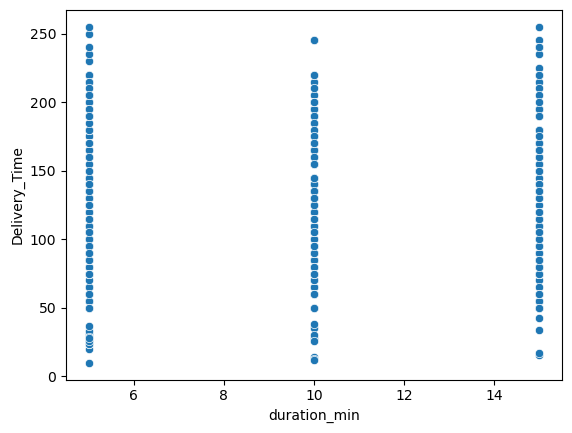

In [162]:
sns.scatterplot(x="duration_min",y="Delivery_Time", data=amazon_sample400)

No correlation.

## **Understanding the relationship between pickup time and delivery time**

In [163]:
print(amazon_sample400["Pickup_Time"].dtype)

object


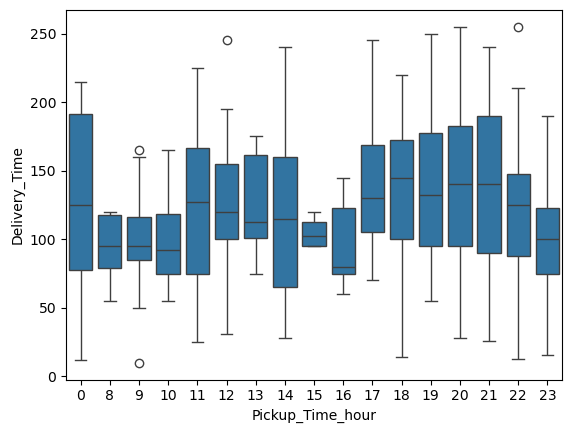

In [177]:
amazon_sample400["Pickup_Time"] = pd.to_datetime(amazon_sample400["Pickup_Time"])
amazon_sample400["Pickup_Time_hour"] = amazon_sample400["Pickup_Time"].dt.hour
amazon_sample400.sort_values(by="Pickup_Time_hour", inplace=True)
sns.boxplot(x="Pickup_Time_hour", y="Delivery_Time", data=amazon_sample400)
plt.show()

We can see that there are no deliveries between 1am and 8am.  
However, delivery at midnight doesn't seem to be an advantage.  
Although a stat would be necessary to confirm, it seems that the shortest delivery happens in the afternon between 16 and 17.  

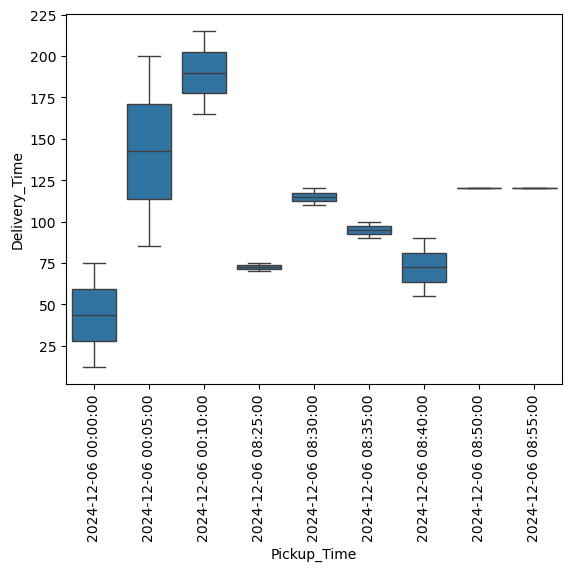

In [176]:
night_Pickup = amazon_sample400[(amazon_sample400["Pickup_Time_hour"] >= 0) & (amazon_sample400["Pickup_Time_hour"] <= 8)]
night_Pickup = night_Pickup.sort_values("Pickup_Time")
sns.boxplot(x="Pickup_Time", y="Delivery_Time", data=night_Pickup)
plt.xticks(rotation=90)
plt.show()

In [172]:
print(amazon_sample400[["Pickup_Time","Pickup_Time_hour"]].head(10))

              Pickup_Time  Pickup_Time_hour
42406 2024-12-06 00:00:00                 0
6607  2024-12-06 00:00:00                 0
37509 2024-12-06 00:05:00                 0
18682 2024-12-06 00:05:00                 0
11368 2024-12-06 00:10:00                 0
23717 2024-12-06 00:10:00                 0
25070 2024-12-06 08:55:00                 8
9178  2024-12-06 08:50:00                 8
20963 2024-12-06 08:40:00                 8
19398 2024-12-06 08:35:00                 8


In [174]:
midnight_pickup = amazon_sample400[amazon_sample400["Pickup_Time_hour"] == 0]
print(midnight_pickup["Delivery_Time"].describe())

pickup_1am = amazon_sample400[amazon_sample400["Pickup_Time_hour"] == 1]
print(pickup_1am["Delivery_Time"].describe())

count      6.000000
mean     125.333333
std       80.241303
min       12.000000
25%       77.500000
50%      125.000000
75%      191.250000
max      215.000000
Name: Delivery_Time, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Delivery_Time, dtype: float64


In [ ]:
#midnight_pickup = amazon_sample400[(amazon_sample400["Pickup_Time"] > "00:00") & (amazon_sample400["Pickup_Time"] < "01:00")]
#print(midnight_pickup.groupby("Traffic")["Delivery_Time"].median())
#print(len(midnight_pickup)/len(amazon_sample400))
#print(midnight_pickup.groupby("Vehicle")["Delivery_Time"].describe())

Traffic
Low       182.5
Medium      NaN
High        NaN
Jam         NaN
Name: Delivery_Time, dtype: float64
0.010050251256281407
            count    mean        std   min    25%    50%     75%    max
Vehicle                                                                
scooter       0.0     NaN        NaN   NaN    NaN    NaN     NaN    NaN
motorcycle    4.0  166.25  58.076817  85.0  145.0  182.5  203.75  215.0
van           0.0     NaN        NaN   NaN    NaN    NaN     NaN    NaN


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\3153942011.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(midnight_pickup.groupby("Traffic")["Delivery_Time"].median())
C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\3153942011.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(midnight_pickup.groupby("Vehicle")["Delivery_Time"].describe())


It seems that delivering just after midnight doesn't give any improvement on the delivery time, even though the traffic is at that time low. 

In [145]:
print(midnight_pickup.groupby("Area")["Delivery_Time"].describe())

              count    mean        std   min    25%    50%     75%    max
Area                                                                     
Other           0.0     NaN        NaN   NaN    NaN    NaN     NaN    NaN
Semi-Urban      0.0     NaN        NaN   NaN    NaN    NaN     NaN    NaN
Urban           0.0     NaN        NaN   NaN    NaN    NaN     NaN    NaN
Metropolitan    4.0  166.25  58.076817  85.0  145.0  182.5  203.75  215.0


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\1597219718.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(midnight_pickup.groupby("Area")["Delivery_Time"].describe())


Furthermore, this Pickup time only concerns the Metropolitan area.  

C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\2017995078.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  amazon_del["Pickup_Time"] = pd.to_datetime(amazon_del["Pickup_Time"])


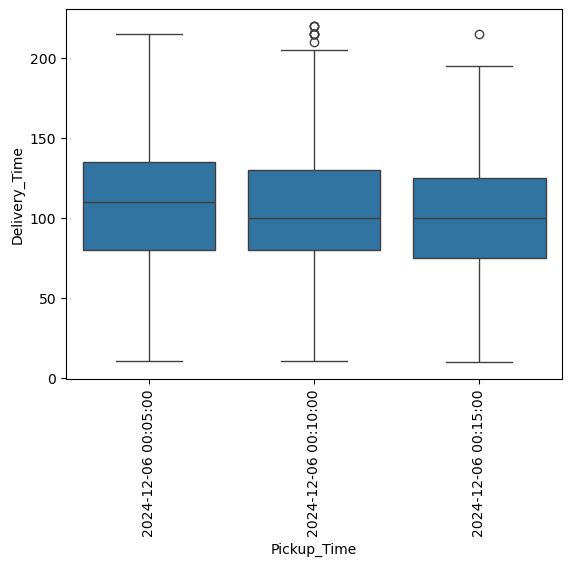

In [146]:
amazon_del["Pickup_Time"] = pd.to_datetime(amazon_del["Pickup_Time"])
amazon_midnight = amazon_del[(amazon_del["Pickup_Time"] > "00:00") & (amazon_del["Pickup_Time"] < "01:00")]
sns.boxplot(x="Pickup_Time", y="Delivery_Time", data=amazon_midnight)
plt.xticks(rotation=90)
plt.show()

In [147]:
print(amazon_midnight.groupby("Traffic")["Delivery_Time"].describe())
print(amazon_midnight["Vehicle"].value_counts())

         count        mean        std   min   25%    50%    75%    max
Traffic                                                               
Low      837.0  106.230585  43.067385  10.0  80.0  105.0  130.0  220.0
Medium     0.0         NaN        NaN   NaN   NaN    NaN    NaN    NaN
Jam        0.0         NaN        NaN   NaN   NaN    NaN    NaN    NaN
High       0.0         NaN        NaN   NaN   NaN    NaN    NaN    NaN
Vehicle
motorcycle    474
scooter       290
van            73
bicycle         0
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\729600194.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(amazon_midnight.groupby("Traffic")["Delivery_Time"].describe())


In [148]:
print(amazon_del.groupby("Traffic")["Delivery_Time"].describe())

           count        mean        std   min    25%    50%    75%    max
Traffic                                                                  
Low      14739.0  101.505258  38.899375  10.0   75.0  100.0  125.0  220.0
Medium   10614.0  126.835029  48.722802  10.0   90.0  130.0  160.0  245.0
Jam      13710.0  147.748505  56.828568  10.0  110.0  150.0  190.0  270.0
High      4217.0  129.465260  48.373108  10.0  100.0  135.0  160.0  270.0


C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\2455931648.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(amazon_del.groupby("Traffic")["Delivery_Time"].describe())


In [149]:
print(amazon_midnight.groupby("Area")["Delivery_Time"].describe())

C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\2360992336.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(amazon_midnight.groupby("Area")["Delivery_Time"].describe())


              count        mean        std   min   25%    50%    75%    max
Area                                                                       
Other          33.0   98.818182  40.251129  21.0  75.0   90.0  110.0  215.0
Semi-Urban      0.0         NaN        NaN   NaN   NaN    NaN    NaN    NaN
Urban         214.0   95.373832  40.494832  11.0  70.0   95.0  120.0  210.0
Metropolitan  590.0  110.583051  43.436221  10.0  80.0  110.0  135.0  220.0


## **Is there a correlation between traffic and Delivery Time?**

In [150]:
amazon_sample400["Traffic"].unique()

['Low', 'High', 'Medium', 'Jam']
Categories (4, object): ['Low' < 'Medium' < 'High' < 'Jam']

In [151]:
amazon_sample400["Traffic"] = amazon_sample400["Traffic"].astype("category")
ordered_traffic = ["Low","Medium","High","Jam"]
amazon_sample400["Traffic"] = amazon_sample400["Traffic"].\
    cat.reorder_categories(new_categories=ordered_traffic, ordered=True)

In [152]:
amazon_sample400.groupby("Traffic")["Delivery_Time"].describe()

C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\1075460086.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amazon_sample400.groupby("Traffic")["Delivery_Time"].describe()


,count,mean,std,min,25%,50%,75%,max
Traffic,,,,,,,,
Low,140.0,103.464286,42.172549,10.0,75.0,100.0,130.0,215.0
Medium,96.0,128.072917,49.690038,14.0,95.0,122.5,165.0,245.0
High,53.0,127.679245,55.876503,25.0,90.0,120.0,165.0,245.0
Jam,109.0,144.944954,57.472511,26.0,105.0,145.0,190.0,255.0


## **Vehicles and traffic and delivery time**

In [153]:
amazon_sample400.groupby(["Vehicle","Traffic"])["Delivery_Time"].median()

C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\1883379857.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amazon_sample400.groupby(["Vehicle","Traffic"])["Delivery_Time"].median()


Vehicle     Traffic
scooter     Low         92.5
            Medium     120.0
            High        92.5
            Jam        140.0
motorcycle  Low        110.0
            Medium     130.0
            High       135.0
            Jam        160.0
van         Low         95.0
            Medium      85.0
            High       120.0
            Jam        125.0
Name: Delivery_Time, dtype: float64

In [154]:
amazon_sample400["Vehicle"].value_counts()

Vehicle
motorcycle    250
scooter       124
van            24
Name: count, dtype: int64

## **What kind of products transport the different vehicles?**

In [155]:
amazon_sample400.groupby("Vehicle")["Category"].value_counts(normalize=True)

C:\Users\Angelique\AppData\Local\Temp\ipykernel_6888\3307035500.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amazon_sample400.groupby("Vehicle")["Category"].value_counts(normalize=True)


Vehicle     Category    
scooter     Clothing        0.088710
            Apparel         0.080645
            Grocery         0.080645
            Electronics     0.072581
            Jewelry         0.072581
            Books           0.064516
            Pet Supplies    0.064516
            Shoes           0.064516
            Skincare        0.064516
            Cosmetics       0.056452
            Home            0.056452
            Sports          0.056452
            Toys            0.056452
            Outdoors        0.048387
            Kitchen         0.040323
            Snacks          0.032258
motorcycle  Kitchen         0.104000
            Snacks          0.084000
            Electronics     0.076000
            Skincare        0.076000
            Cosmetics       0.072000
            Toys            0.068000
            Books           0.064000
            Clothing        0.060000
            Sports          0.060000
            Apparel         0.052000
            G